In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
import tensorflow as tf

# Restrict TensorFlow to only use the first GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Optional: Set memory growth to prevent TensorFlow from reserving all GPU memory
        tf.config.experimental.set_memory_growth(gpus[0], True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [ ]:
from google.colab import drive
drive.mount('/content/drive') # for google colab to access google drive

Mounted at /content/drive


In [ ]:
import xml.etree.ElementTree as ET
import os
import pandas as pd
from sklearn.utils import shuffle
import calendar
from sklearn.preprocessing import StandardScaler
import numpy as np

# Path to your XML files
xml_folder = '/content/drive/My Drive/Colab Notebooks/Independent Study/Data/xml'

# List all XML files in the directory
xml_files = [f for f in os.listdir(xml_folder) if f.endswith('.xml')]

# Initialize an empty list to store data from all XML files
all_data = []

# Loop through each file in the XML directory
for file_name in xml_files:
    file_path = os.path.join(xml_folder, file_name)
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Extract data from each <TestbedMonJun14Flows> element (adjust tag as needed)
        for flow in root.findall('./*'):  # Check if this tag needs to be adjusted
            flow_data = {
                'appName': flow.find('appName').text if flow.find('appName') is not None else None,
                'totalSourceBytes': flow.find('totalSourceBytes').text if flow.find('totalSourceBytes') is not None else None,
                'totalDestinationBytes': flow.find('totalDestinationBytes').text if flow.find('totalDestinationBytes') is not None else None,
                'totalSourcePackets': flow.find('totalSourcePackets').text if flow.find('totalSourcePackets') is not None else None,
                'direction': flow.find('direction').text if flow.find('direction') is not None else None,
                'source': flow.find('source').text if flow.find('source') is not None else None,
                'protocolName': flow.find('protocolName').text if flow.find('protocolName') is not None else None,
                'sourcePort': flow.find('sourcePort').text if flow.find('sourcePort') is not None else None,
                'destination': flow.find('destination').text if flow.find('destination') is not None else None,
                'destinationPort': flow.find('destinationPort').text if flow.find('destinationPort') is not None else None,
                'startDateTime': flow.find('startDateTime').text if flow.find('startDateTime') is not None else None,
                'stopDateTime': flow.find('stopDateTime').text if flow.find('stopDateTime') is not None else None,
                'Tag': flow.find('Tag').text if flow.find('Tag') is not None else None
            }
            all_data.append(flow_data)
    except ET.ParseError as pe:
        print(f"Error parsing {file_name}: {pe}")

# Convert list to DataFrame
df = pd.DataFrame(all_data)

# Display the DataFrame
print(df.head())

def create_balanced_batches(df, batch_size=100, min_attacks=4):
    # Separate attack and normal instances
    attacks = df[df['Tag'] == 'Attack']
    normals = df[df['Tag'] == 'Normal']

    # Shuffle both datasets
    attacks = shuffle(attacks)
    normals = shuffle(normals)

    batches = []
    num_batches = len(df) // batch_size

    for _ in range(num_batches):
        if len(attacks) >= min_attacks and len(normals) >= (batch_size - min_attacks):
            # Take min_attacks from attacks and fill the rest with normals
            batch = pd.concat([
                attacks.iloc[:min_attacks],
                normals.iloc[:(batch_size - min_attacks)]
            ])
            # Shuffle the batch to mix attacks and normals
            batch = shuffle(batch)
            batches.append(batch)

            # Remove selected samples
            attacks = attacks.iloc[min_attacks:]
            normals = normals.iloc[batch_size - min_attacks:]
        else:
            break  # Break if there aren't enough samples to fill a batch as specified

    # Add remaining samples to a final batch if not empty
    if not attacks.empty or not normals.empty:
        remaining_batch = pd.concat([attacks, normals])
        remaining_batch = shuffle(remaining_batch)
        batches.append(remaining_batch)

    # Concatenate all batches back into a single DataFrame
    new_df = pd.concat(batches).reset_index(drop=True)
    return new_df

# Assuming df is your original DataFrame
new_df = create_balanced_batches(df)

# See how many duplicate entries there are in new_df
duplicates = new_df.duplicated().sum()
original_len = len(new_df)
print(f"Number of duplicate entries: {duplicates}")
print(f"Original DataFrame length: {original_len}")
print(original_len - duplicates)

# Drop the duplicates
new_df = new_df.drop_duplicates()
print(new_df.shape)

# Calculate the correlation matrix as you have already done
tag_mapping = {'Normal': 0, 'Attack': 1}
new_df['Tag'] = new_df['Tag'].map(tag_mapping)

# Function to convert numeric month and weekday to names
def process_LLM_datetime(df):
    df = df.copy()  # Create a copy of the DataFrame to avoid modifying the original
    to_check = ['month', 'weekday']
    for col in to_check:
        if col == 'month':
            df[col] = df[col].apply(lambda x: calendar.month_name[x])
        elif col == 'weekday':
            df[col] = df[col].apply(lambda x: calendar.day_name[x])
    return df

# Convert to datetime if not already done
new_df['startDateTime'] = pd.to_datetime(new_df['startDateTime'])
new_df['stopDateTime'] = pd.to_datetime(new_df['stopDateTime'])

# Extract date and time components from startDateTime
new_df['year'] = new_df['startDateTime'].dt.year
new_df['month'] = new_df['startDateTime'].dt.month
new_df['day'] = new_df['startDateTime'].dt.day
new_df['weekday'] = new_df['startDateTime'].dt.weekday
new_df['dayofyear'] = new_df['startDateTime'].dt.dayofyear
new_df['hour'] = new_df['startDateTime'].dt.hour
new_df['minute'] = new_df['startDateTime'].dt.minute
new_df['second'] = new_df['startDateTime'].dt.second

# Calculate duration in seconds
new_df['duration_seconds'] = (new_df['stopDateTime'] - new_df['startDateTime']).dt.total_seconds()

# Remove start and stop features
new_df = new_df.drop(['startDateTime', 'stopDateTime'], axis=1)

# Create a copy for LLM processing
df_llm = new_df.copy()

# Apply the process_LLM_datetime function to the df_llm copy
df_llm = process_LLM_datetime(df_llm)

print("\nLLM Processed DataFrame (df_llm):")
print(df_llm.head())

x = df_llm.drop('Tag', axis=1)
y = df_llm['Tag']

# Specify columns to normalize
columns_to_normalize = ['totalSourceBytes', 'totalDestinationBytes', 'totalSourcePackets', 'duration_seconds']

# Use StandardScaler to normalize specified columns
scaler = StandardScaler()
x[columns_to_normalize] = scaler.fit_transform(x[columns_to_normalize])

# Helper function to convert a data row to textual format
def textualize(X):
    textual_data = []
    for index, row in enumerate(X.values):
        row_textual = [f"{col}: {val}" for col, val in zip(X.columns, row)]
        textual_data.append(' '.join(row_textual))
    return textual_data

x_textual = textualize(x)

print(x_textual[0])

Error parsing TestbedThuJun17-1Flows.xml: not well-formed (invalid token): line 3135760, column 209
             appName totalSourceBytes totalDestinationBytes  \
0        Unknown_UDP            16076                     0   
1  HTTPImageTransfer              384                     0   
2                DNS              171                   642   
3  HTTPImageTransfer              384                     0   
4  HTTPImageTransfer              186                   128   

  totalSourcePackets direction         source protocolName sourcePort  \
0                178       L2R  192.168.5.122       udp_ip       5353   
1                  6       L2R  192.168.2.111       tcp_ip       4435   
2                  2       L2L  192.168.4.119       udp_ip       4428   
3                  6       L2R  192.168.4.119       tcp_ip       3639   
4                  2       L2R  192.168.4.119       tcp_ip       3641   

       destination destinationPort        startDateTime         stopDateTime  \
0 

In [ ]:
# columns to normalize
# totalSOurceBytes, TotalDestinationBytes, totalSOurceBytes, duration_seconds

In [ ]:
print(x_textual[0])

appName: DNS totalSourceBytes: 93 totalDestinationBytes: 259 totalSourcePackets: 1 direction: L2R source: 192.168.5.122 protocolName: udp_ip sourcePort: 32524 destination: 198.164.30.2 destinationPort: 53 year: 0.0 month: June day: 0.6878656736573798 weekday: Wednesday dayofyear: 0.6878656736573903 hour: -0.3664248069871792 minute: -1.3651934809988238 second: -0.22107035975083586 duration_seconds: -0.08136224594522481


In [ ]:
# Tokenize and process the dataset
def preprocess_text(texts):
    # Extract numeric values and replace them with [NUM] token
    numeric_values = []
    processed_texts = []
    for text in texts:
        tokens = text.split()
        processed_tokens = []
        for token in tokens:
            try:
                value = float(token)
                processed_tokens.append("[NUM]")
                numeric_values.append(value)
            except ValueError:
                processed_tokens.append(token)
        processed_texts.append(" ".join(processed_tokens))
    return processed_texts, numeric_values


processed_texts, numeric_values = preprocess_text(x_textual)


In [ ]:
print(processed_texts[0])
print(numeric_values[0])

appName: Unknown_UDP totalSourceBytes: [NUM] totalDestinationBytes: [NUM] totalSourcePackets: [NUM] direction: L2R source: 192.168.2.107 protocolName: udp_ip sourcePort: [NUM] destination: 24.62.239.208 destinationPort: [NUM] year: [NUM] month: June day: [NUM] weekday: Sunday dayofyear: [NUM] hour: [NUM] minute: [NUM] second: [NUM] duration_seconds: [NUM]
389.0


In [ ]:
print(len(processed_texts))
print(len(y))

1746630
1746630


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer


# Convert processed_text and y into pandas DataFrames
processed_text = pd.DataFrame({'text': x_textual})
labels = pd.DataFrame(y)

# Reset indices to ensure alignment
processed_text.reset_index(drop=True, inplace=True)
labels.reset_index(drop=True, inplace=True)

print(processed_text.shape)
print(labels.shape)

# Concatenate processed_text and y into a single DataFrame
data_ready = pd.concat([processed_text, labels], axis=1)


# Rename columns to "text" and "label"
data_ready.columns = ["text", "label"]

print(data_ready.head())


(1746630, 1)
(1746630, 1)
                                                text  label
0  appName: HTTPImageTransfer totalSourceBytes: -...      0
1  appName: HTTPImageTransfer totalSourceBytes: -...      0
2  appName: Unknown_UDP totalSourceBytes: -0.0028...      0
3  appName: DNS totalSourceBytes: -0.003100816308...      0
4  appName: DNS totalSourceBytes: -0.002576579650...      0


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Define parameters
vocab_size = 20000
sequence_length = 600

# Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(processed_texts)

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(processed_texts)

# Pad the sequences to ensure they are all the same length
padded_sequences = pad_sequences(sequences, maxlen=sequence_length, padding='post')

# Normalize numeric values to fit within the embedding range (e.g., 0 to 1)
numeric_values = np.array(numeric_values)
numeric_values = (numeric_values - numeric_values.min()) / (numeric_values.max() - numeric_values.min())

# Pad numeric values to match the sequence length
padded_numeric_values = pad_sequences([numeric_values], maxlen=sequence_length, padding='post')[0]

# Split the data into training and test sets
x_train_text, x_test_text, y_train, y_test = train_test_split(padded_sequences, data_ready['label'], test_size=0.2, random_state=42)
x_train_num, x_test_num = train_test_split(padded_numeric_values, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
x_train_text, x_val_text, y_train, y_val = train_test_split(x_train_text, y_train, test_size=0.2, random_state=42)
x_train_num, x_val_num = train_test_split(x_train_num, test_size=0.2, random_state=42)

# Create TensorFlow Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices(((x_train_text, x_train_num), y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(((x_val_text, x_val_num), y_val)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices(((x_test_text, x_test_num), y_test)).batch(32)


ValueError: Dimensions 1117843 and 384 are not compatible

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define parameters
vocab_size = 17733
sequence_length = 50

# Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data_ready['text'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(data_ready['text'])

# Pad the sequences to ensure they are all the same length
padded_sequences = pad_sequences(sequences, maxlen=sequence_length, padding='post')


In [ ]:
import matplotlib.pyplot as plt

# Get the word counts
word_counts = tokenizer.word_counts
sorted_word_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)
total_counts = sum(word_counts.values())

# Calculate cumulative coverage
cumulative_coverage = 0
coverage_threshold = 0.99
vocab_size_optimal = 0
for i, (word, count) in enumerate(sorted_word_counts):
    cumulative_coverage += count / total_counts
    if cumulative_coverage >= coverage_threshold:
        vocab_size_optimal = i + 1
        break

print(f"Optimal vocab size for {coverage_threshold*100}% coverage: {vocab_size_optimal}")



Optimal vocab size for 99.0% coverage: 17733


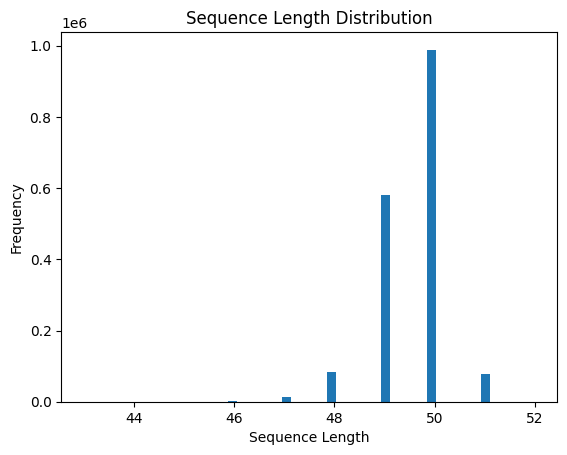

Optimal sequence length to cover 95% of data: 50


In [ ]:
# Analyze sequence lengths
sequence_lengths = [len(seq) for seq in sequences]
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Sequence Length Distribution')
plt.show()

# Choose optimal sequence length
sequence_length_optimal = int(np.percentile(sequence_lengths, 95))
print(f"Optimal sequence length to cover 95% of data: {sequence_length_optimal}")


In [ ]:

from sklearn.model_selection import train_test_split
import tensorflow as tf

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, data_ready['label'], test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Create TensorFlow Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)


In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, data_ready['label'], test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Create TensorFlow Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Define the custom PositionalEmbedding layer
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

# Define the custom TransformerEncoder layer
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim)])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

# Define model parameters
embed_dim = 256
num_heads = 2
dense_dim = 32

# Build the model
inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

# Train the model
#callbacks = [keras.callbacks.ModelCheckpoint("transformer_encoder.keras", save_best_only=True)]

callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]



model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=callbacks)

# Load the best model and evaluate
model = keras.models.load_model("transformer_encoder.keras", custom_objects={"TransformerEncoder": TransformerEncoder, "PositionalEmbedding": PositionalEmbedding})


print(f"Test accuracy: {model.evaluate(test_dataset)[1]:.3f}")


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posi  (None, None, 256)         4552448   
 tionalEmbedding)                                                
                                                                 
 transformer_encoder (Trans  (None, None, 256)         543776    
 formerEncoder)                                                  
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

In [ ]:
# Generate predictions for the test set
predictions = model.predict(test_dataset)
# Convert probabilities to binary predictions
binary_predictions = (predictions > 0.5).astype(int)
# Assuming you have the true labels stored in `test_labels`
from sklearn.metrics import classification_report
print(classification_report(y_test, binary_predictions))


10917/10917 [==============================] - 49s 4ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    337617
           1       1.00      1.00      1.00     11709

    accuracy                           1.00    349326
   macro avg       1.00      1.00      1.00    349326
weighted avg       1.00      1.00      1.00    349326

